In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [108]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'aizarani']
# DS_LIST = ['facs', 'droplet', 'canogamez']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Human liver'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.gwas_max_abs_z.top500',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.gwas_max_abs_z.top500',
                  'aizarani': DATA_PATH+'/score_file/score.liver_atlas.gwas_max_abs_z.top500'}

# TRAIT_LIST = ['PASS_IBD', 
#               'PASS_Rheumatoid_Arthritis', 
#               'PASS_AdultOnsetAsthma_Ferreira2019', 
#               'UKB_460K.disease_AID_ALL', 
#               'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
#               'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP']

# DIC_TRAIT_NAME = {'PASS_IBD': 'IBD', 'PASS_IBD_deLange2017': 'IBD_deLange2017', 'PASS_Multiple_sclerosis': 'MS',
#                   'PASS_Rheumatoid_Arthritis': 'RA', 'PASS_AdultOnsetAsthma_Ferreira2019':'ASTHMA_Ferreira2019', 
#                   'UKB_460K.disease_ASTHMA_DIAGNOSED':'ASTHMA', 'UKB_460K.blood_LYMPHOCYTE_COUNT':'LYMPH_COUNT',
#                   'UKB_460K.disease_AID_ALL':'AID', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED':'ECZEMA',
#                   'UKB_460K.disease_DERMATOLOGY':'DERMATOLOGY', 
#                   'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP':'HT', 
#                   'UKB_460K.disease_RESPIRATORY_ENT':'RESPIRATORY_ENT'}

# FIG_PATH = ''

In [7]:
# Maybe only take out the liver hepatocyte data 
dic_data_raw = {}
dic_data_proc = {}

# TMS FACs 
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_proc['facs'] = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='Liver')['Liver']

# TMS droplet 
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_proc['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']

# Aizarani et al. Liver atlas
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_proc['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

DNAME_LIST = list(dic_data_raw.keys())

Trying to set attribute `.obs` of view, copying.


# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# load_tms_processed: load droplet data, tissue=[Bladder, Fat, Heart_and_Aorta, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, Mammary_Gland, Marrow, Pancreas, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [10]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for ds in DS_LIST:
#     for trait in TRAIT_LIST:
    for filename in [x for x in os.listdir(DIC_SCORE_PATH[ds]) if '.score.gz' in x]:
        trait = filename.replace('.score.gz','')
        file_path = join(DIC_SCORE_PATH[ds], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[ds] = pd.concat([dic_score[ds], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[ds].index))

### Associations (neuron)

In [37]:
# celltype_list = ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'ependymal cell',
#                  'interneuron', 'medium spiny neuron', 'neuroepithelial cell', 'neuron',
#                  'neuronal stem cell', 'oligodendrocyte', 'oligodendrocyte precursor cell']
# cell_list = dic_data_raw['facs'].obs_names[dic_data_raw['facs'].obs['cell_ontology_class'].isin(celltype_list)]
# cell_list = list(set(cell_list) & set(dic_score['facs'].index))
# trait_list = [x.replace('.norm_score','') for x in dic_score['facs'].columns if '.norm_score' in x]
# df_stats = pd.DataFrame(index=celltype_list, columns=trait_list, data=0)

# for trait in trait_list:
#     temp_df = dic_score['facs'].loc[cell_list, ['%s.fdr'%trait]].copy()<0.2
#     if temp_df['%s.fdr'%trait].sum()<50:
#         continue
# #     else:
# #         print(trait, temp_df['%s.fdr'%trait].sum())
#     temp_df = temp_df.join(dic_data_raw['facs'].obs[['cell_ontology_class']])
#     temp_df = temp_df.groupby('cell_ontology_class').agg({'%s.fdr'%trait:np.mean})
#     df_stats[trait] = temp_df.loc[celltype_list, '%s.fdr'%trait].values
# df_stats = df_stats.loc[:, (df_stats>0.1).sum(axis=0)>0].T
# df_stats.to_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/assoc_brain.tsv', sep='\t')

In [39]:
# traits associated with hepatocyte
trait_list = []
cell_list = dic_data_raw['facs'].obs_names[dic_data_raw['facs'].obs['cell_ontology_class']=='hepatocyte']
for trait in [x.replace('.norm_score','') for x in dic_score['facs'].columns if '.norm_score' in x]:
    temp_df = dic_score['facs'].loc[cell_list, ['%s.fdr'%trait]].copy()<0.2
    if temp_df['%s.fdr'%trait].mean()>0.1:
        trait_list.append(trait)
        print(trait, temp_df['%s.fdr'%trait].mean())

UKB_460K.biochemistry_LipoproteinA 0.10757314974182444
UKB_460K.biochemistry_DirectBilirubin 0.14457831325301204
UKB_460K.biochemistry_AlanineAminotransferase 0.3046471600688468
UKB_460K.biochemistry_Testosterone_Male 0.12908777969018934
UKB_460K.disease_HI_CHOL_SELF_REP 0.16523235800344235
UKB_460K.biochemistry_ApolipoproteinA 0.685025817555938
UKB_460K.biochemistry_ApolipoproteinB 0.7753872633390706
UKB_460K.biochemistry_LDLdirect 0.6858864027538726
UKB_460K.biochemistry_Cholesterol 0.6678141135972461
UKB_460K.biochemistry_SHBG 0.31153184165232356
UKB_460K.biochemistry_AlkalinePhosphatase 0.4664371772805508
UKB_460K.biochemistry_VitaminD 0.6746987951807228
PASS_LDL 0.45869191049913943
UKB_460K.biochemistry_Triglycerides 0.6807228915662651
UKB_460K.biochemistry_HDLcholesterol 0.3123924268502582


### Prioritize gene sets 

In [40]:
df_gs_gwas = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs',
                         sep='\t', index_col=0)
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                             'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [42]:
# GWAS and scTRS gene sets 
dic_gs = {}
cell_list = dic_data_raw['facs'].obs_names[dic_data_raw['facs'].obs['cell_ontology_class']=='hepatocyte']
temp_adata = dic_data_raw['facs'][cell_list, list(background_set)].copy()

for trait in trait_list:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])

In [101]:
# Gold standard gene sets 
dic_ref = {'UKB_460K.biochemistry_DirectBilirubin': 'Forgetta_biorxiv_2020:dbilirubin.med',
           'UKB_460K.biochemistry_LDLdirect': 'Forgetta_biorxiv_2020:ldl.med;Forgetta_biorxiv_2020:ldl.drug',
           'UKB_460K.biochemistry_Triglycerides': 'Forgetta_biorxiv_2020:tg.med;Forgetta_biorxiv_2020:tg.drug',
           'UKB_460K.biochemistry_Cholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease',
           'UKB_460K.biochemistry_HDLcholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease'}
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Freund_AJHG_2018', 'Forgetta_biorxiv_2020']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
#     break
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [102]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

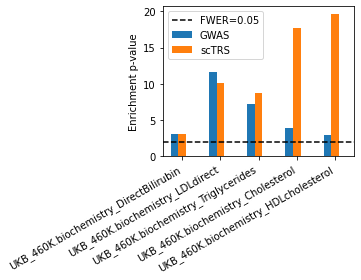

In [109]:
dic_config = {'gwas': ['C0', 'GWAS'], 
              'sctrs': ['C1', 'scTRS']}

df_plot = dic_stats[res][['GS']].copy()
for res in ['gwas', 'sctrs']:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
#     df_plot['%s.or'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio']
#     df_plot['%s.or_lb'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.lb']
#     df_plot['%s.or_ub'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.ub']
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])


plt.figure(figsize=[5, 4])
for i_res,res in enumerate(['gwas', 'sctrs']):
    mat_xerr = np
    plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
            width=0.2, color=dic_config[res][0], label=dic_config[res][1])

fwer_thres = -np.log10(0.05/df_plot.shape[0])
plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
         label='FWER=0.05')

plt.legend()
plt.xticks(df_plot['loc'], [x for x in df_plot.index], rotation=30, ha='right')
plt.ylabel('Enrichment p-value')
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs.svg')
plt.show()

In [104]:
dic_stats['sctrs']

,GWAS,GS,overlap,odds_ratio,odds_ratio.ub,odds_ratio.lb,pval,overlap_gene
UKB_460K.biochemistry_DirectBilirubin,414.0,2.0,2.0,inf,0.000000,0.000000,7.799119e-04,"Abcc2,Ugt1a1"
UKB_460K.biochemistry_LDLdirect,422.0,21.0,10.0,31.716681,75.099224,13.394917,8.475291e-11,"Abca1,Apoa5,Apob,Apoe,Dhcr7,Itih4,Ldlr,Lipa,Mt..."
UKB_460K.biochemistry_Triglycerides,413.0,21.0,9.0,26.699257,63.723393,11.186635,2.046533e-09,"Abca1,Apoa5,Apob,Apoe,Dhcr7,Itih4,Ldlr,Lipa,Mttp"
UKB_460K.biochemistry_Cholesterol,422.0,545.0,58.0,4.547262,6.086008,3.397562,2.232077e-18,"Abca1,Abcc6,Abcg5,Agt,Alb,Angptl4,Apoa1,Apoa5,..."
UKB_460K.biochemistry_HDLcholesterol,396.0,545.0,59.0,5.016272,6.710714,3.749673,2.008805e-20,"Abca1,Abcc6,Agt,Alb,Angptl4,Apoa1,Apoa5,Apob,A..."


In [105]:
dic_stats['gwas']

,GWAS,GS,overlap,odds_ratio,odds_ratio.ub,odds_ratio.lb,pval,overlap_gene
UKB_460K.biochemistry_DirectBilirubin,414.0,2.0,2.0,inf,0.000000,0.000000,7.799119e-04,"Abcc2,Ugt1a1"
UKB_460K.biochemistry_LDLdirect,422.0,21.0,11.0,38.473236,91.098691,16.248201,2.417164e-12,"Abca1,Angptl3,Apoa5,Apob,Apoe,Hmgcr,Ldlr,Ldlra..."
UKB_460K.biochemistry_Triglycerides,413.0,21.0,8.0,21.851472,53.012633,9.007039,5.067370e-08,"Abca1,Angptl3,Apoa5,Apob,Apoe,Itih4,Lpl,Ppara"
UKB_460K.biochemistry_Cholesterol,422.0,545.0,32.0,2.218743,3.215472,1.530980,1.080804e-04,"Abca1,Abcg5,Abcg8,Angptl3,Apoa1,Apoa5,Apob,Apo..."
UKB_460K.biochemistry_HDLcholesterol,396.0,545.0,28.0,2.044782,3.032632,1.378714,9.769840e-04,"Abca1,Akt1,Angptl4,Apoa1,Apoa5,Apob,Apoe,Cpt1a..."
